In [135]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge
import torch
import pandas as pd
from lexical_diversity import lex_div as ld
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

In [136]:
model_name = 'declare-lab/flan-alpaca-large'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.config.output_attentions = True

In [137]:
def get_response_and_scores(prompt, reference):

    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    input_ids = tokenizer.encode(response, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        
    loss = outputs.loss
    perplexity = torch.exp(loss)

    rouge = Rouge()
    scores = rouge.get_scores(response, reference)

    words = response.split()
    mtld_score = ld.mtld(words)

    response_length = len(response)

    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Recall': [scores[0]['rouge-1']['r'], scores[0]['rouge-2']['r'], scores[0]['rouge-l']['r']],
        'Precision': [scores[0]['rouge-1']['p'], scores[0]['rouge-2']['p'], scores[0]['rouge-l']['p']],
        'F1 Score': [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']],
    })

    print(f'ROUGE scores\n{df}')

    return response, perplexity.item(), scores, mtld_score, response_length

In [152]:
new_prompt = "Imagine you are an artificial intelligence expert. Explain how transformer architectures work"

In [139]:
reference_text = "Sports, spanning from traditional games like football and tennis to emerging fields like eSports, involve strategic, psychological, nutritional, and physical aspects, and they play a significant role in international unity, technological advancement, scientific understanding, and personal development."
response, perplexity, rouge_scores, mtld, response_length = get_response_and_scores(new_prompt, reference_text)
print('\nResponse:', response)
print('Perplexity:', perplexity)
print('MTLD:', mtld)
print('Response length:', response_length)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


ROUGE scores
    Metric    Recall  Precision  F1 Score
0  ROUGE-1  0.090909   0.096774   0.09375
1  ROUGE-2  0.000000   0.000000   0.00000
2  ROUGE-L  0.060606   0.064516   0.06250

Response: Transformer architectures have revolutionized the AI landscape by allowing for the development of powerful, efficient, and scalable AI systems. Transformers are based on the idea of a transformer, which is a type of computer architecture that allows
Perplexity: 1.3504736423492432
MTLD: 63.88666666666667
Response length: 249


In [140]:
def visualize_attention(prompt, response):
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(f'Averaged Attention Map Flan-Alpaca (Baseline)')
    plt.colorbar(cax)
    plt.show()

In [141]:
response = response.split(".")[0] + "."

/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_64158/2625562848.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_64158/2625562848.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


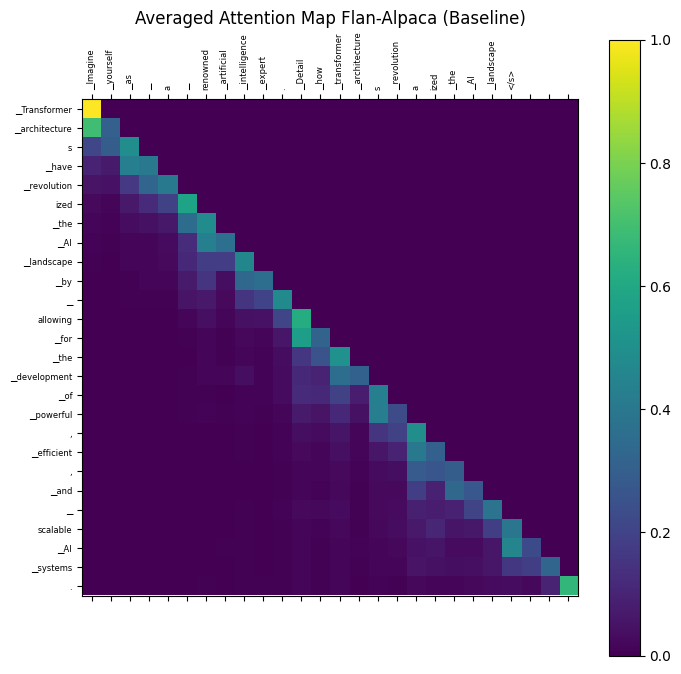

In [142]:
visualize_attention(new_prompt, response)

In [143]:
def visualize_attention_per_head(prompt, response):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")

    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()

    num_heads = attention_weights.shape[0]
    

    grid_size = int(math.ceil(math.sqrt(num_heads)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.ravel()  

    for head in range(num_heads):
        cax = axs[head].matshow(attention_weights[head], cmap='viridis')
        
        src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
        
        axs[head].set_xticks(range(len(src_tokens)))
        axs[head].set_yticks(range(len(tgt_tokens)))
        axs[head].set_xticklabels(src_tokens, rotation=90, fontsize=6)
        axs[head].set_yticklabels(tgt_tokens, fontsize=6)
        axs[head].set_title(f'Flan-Alpaca Head {head+1} (RPP)')
        fig.colorbar(cax, ax=axs[head], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    fig.savefig('attention_heads_rpp_alpaca.png', dpi=300)

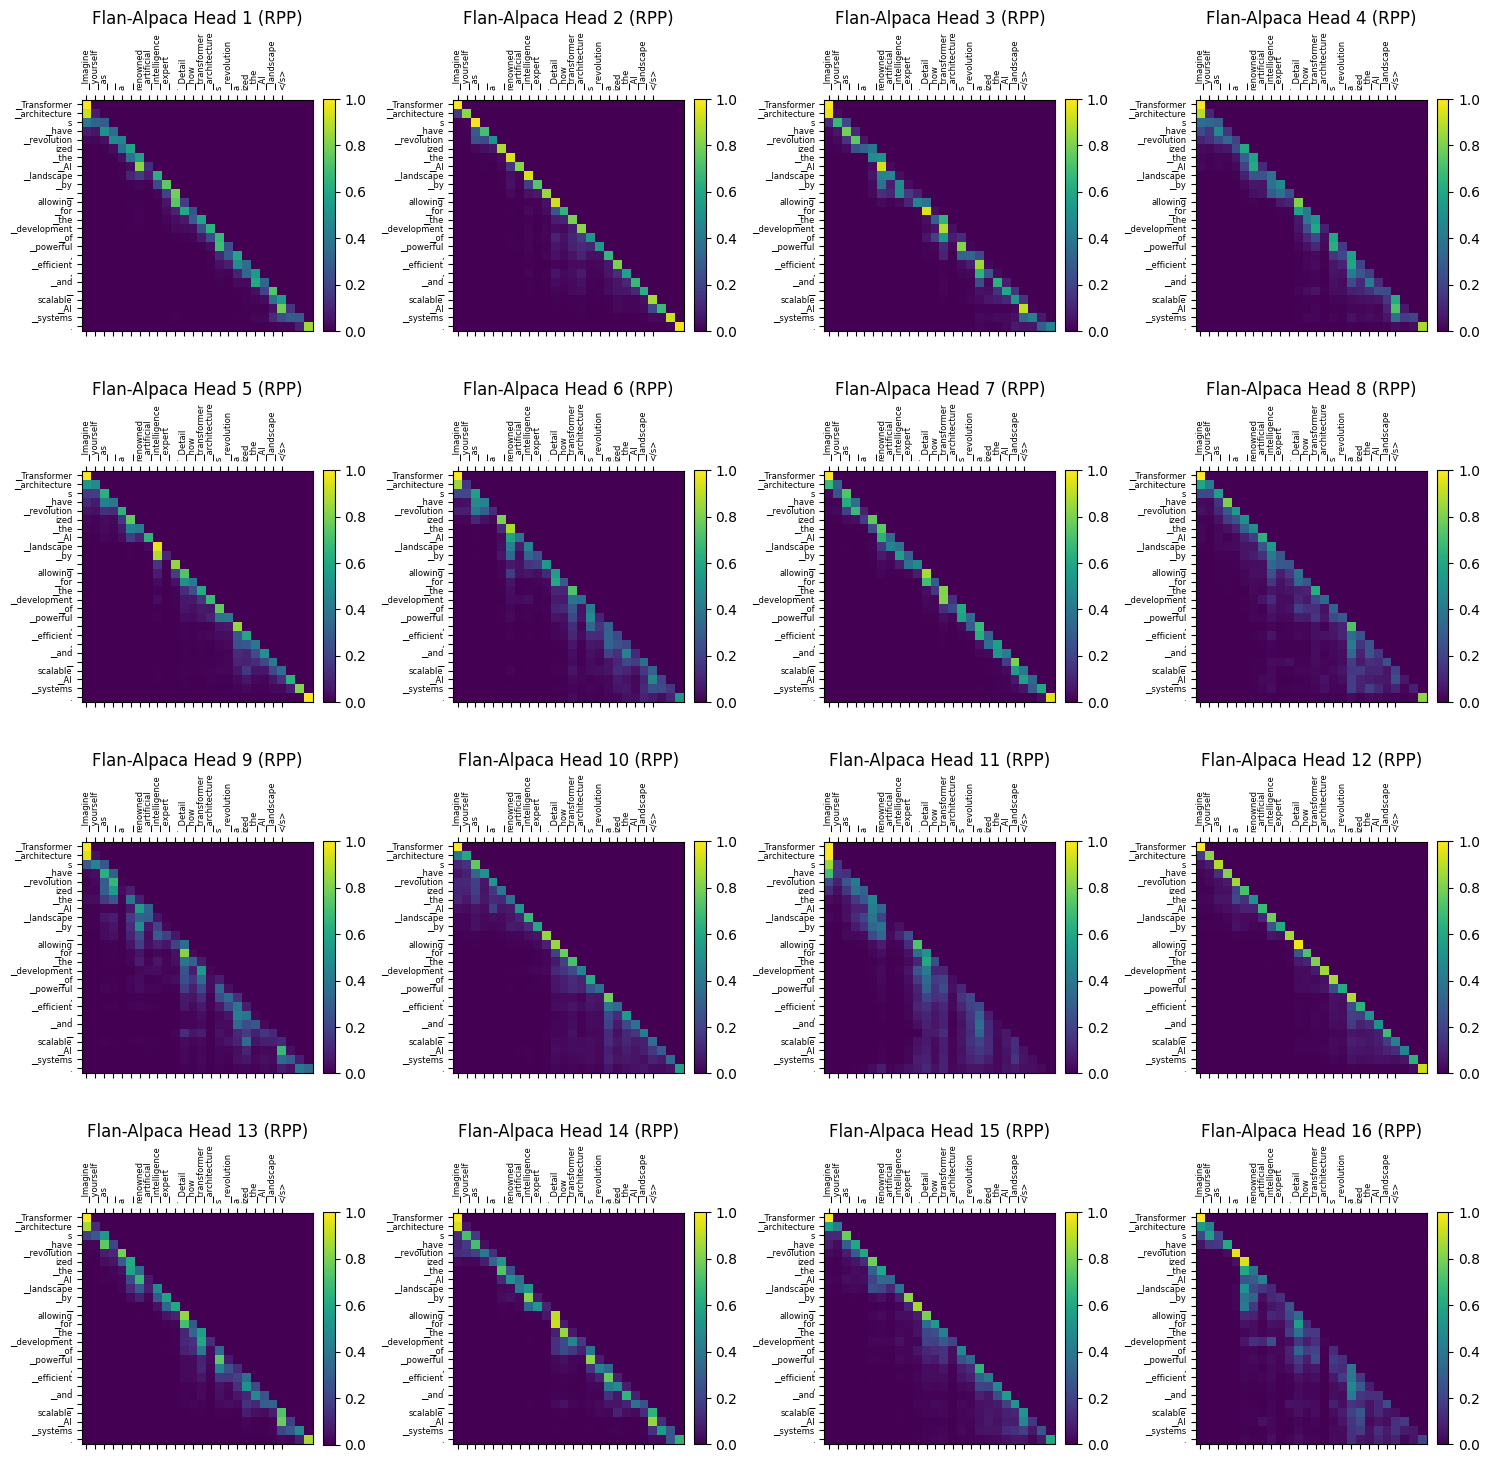

In [144]:
visualize_attention_per_head(new_prompt, response)

In [145]:
def visualize_bar_attention_for_token(prompt, response, token_of_interest):
    
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Find index of the token of interest
    token_index = input_ids[0].tolist().index(tokenizer.encode(token_of_interest, add_special_tokens=False)[0])
    
    # Extract attention weights for the token of interest
    attention_for_token = attention_weights[:, token_index, :]
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_for_token, axis=0)
    
    # Tokens in the response
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    # Plot bar chart
    plt.figure(figsize=(12,6))
    plt.bar(tgt_tokens, attention_weights_avg)
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel('Attention Weight', fontsize=12)
    plt.title(f'Averaged Attention Weights for Token "{token_of_interest}"', fontsize=14)
    plt.tight_layout()
    plt.show()

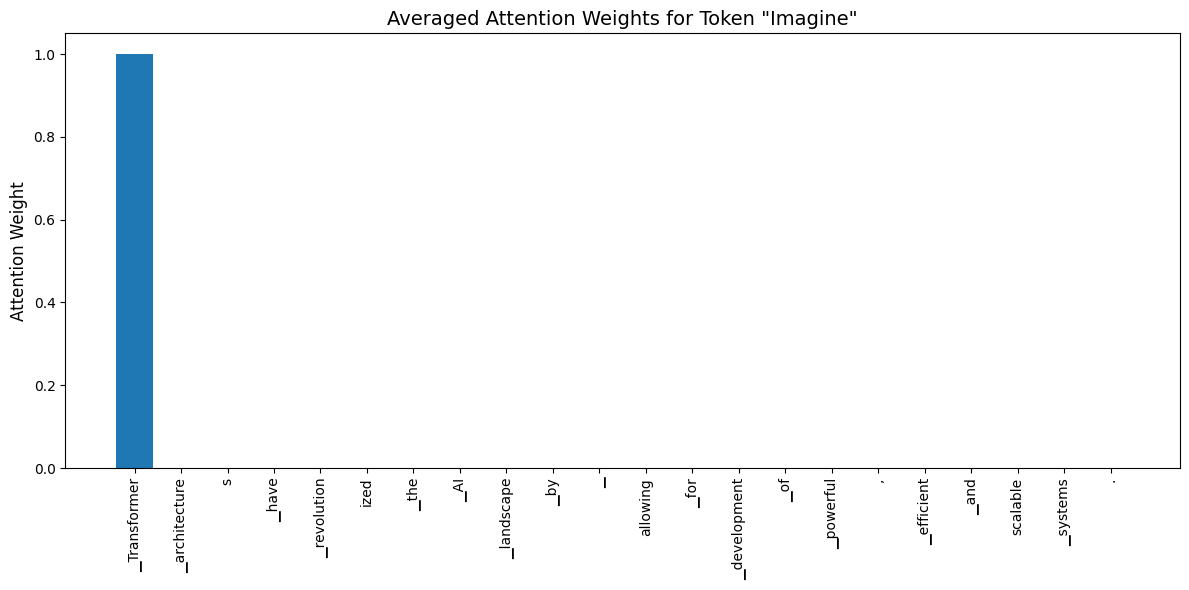

In [146]:
visualize_bar_attention_for_token(new_prompt, response, "Imagine")

In [153]:
def visualize_encoder_attention(prompt):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Create dummy decoder input to satisfy the model's requirements
    dummy_decoder_input = torch.zeros_like(input_ids)
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=dummy_decoder_input, output_attentions=True)
    attention_weights = outputs.encoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    
    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels(src_tokens, fontsize=6)
    
    plt.title(f'Averaged Encoder Self-Attention Map')
    plt.colorbar(cax)
    plt.show()

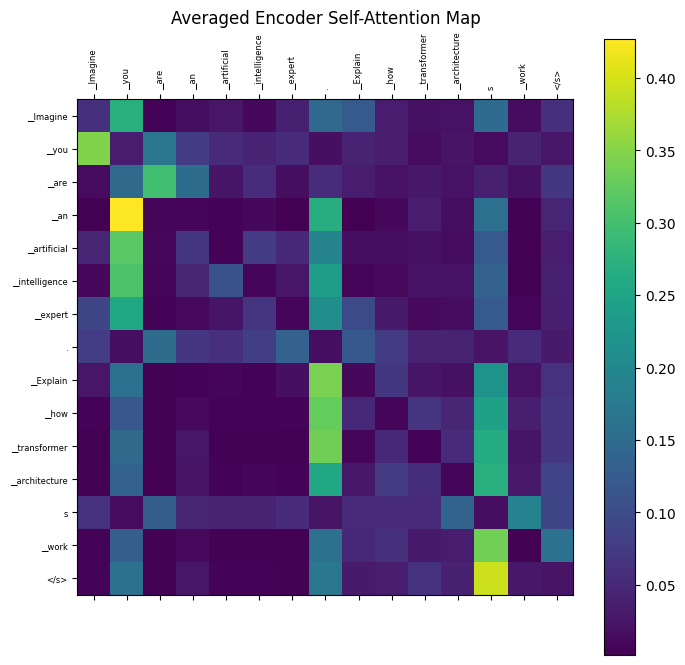

In [154]:
visualize_encoder_attention(new_prompt)

In [150]:
import math

def visualize_encoder_attention_per_head(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Create dummy decoder input to satisfy the model's requirements
    dummy_decoder_input = torch.zeros_like(input_ids)
    
    outputs = model(input_ids, decoder_input_ids=dummy_decoder_input, output_attentions=True)
    attention_weights = outputs.encoder_attentions[-1][0].squeeze().cpu().detach().numpy()

    num_heads = attention_weights.shape[0]
    
    grid_size = int(math.ceil(math.sqrt(num_heads)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.ravel()

    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    
    for head in range(num_heads):
        cax = axs[head].matshow(attention_weights[head], cmap='viridis')
        
        axs[head].set_xticks(range(len(src_tokens)))
        axs[head].set_yticks(range(len(src_tokens)))
        axs[head].set_xticklabels(src_tokens, rotation=90, fontsize=6)
        axs[head].set_yticklabels(src_tokens, fontsize=6)
        axs[head].set_title(f'Head {head+1} Encoder Self-Attention')
        fig.colorbar(cax, ax=axs[head], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    fig.savefig('encoder_self_attention_heads.png', dpi=300)

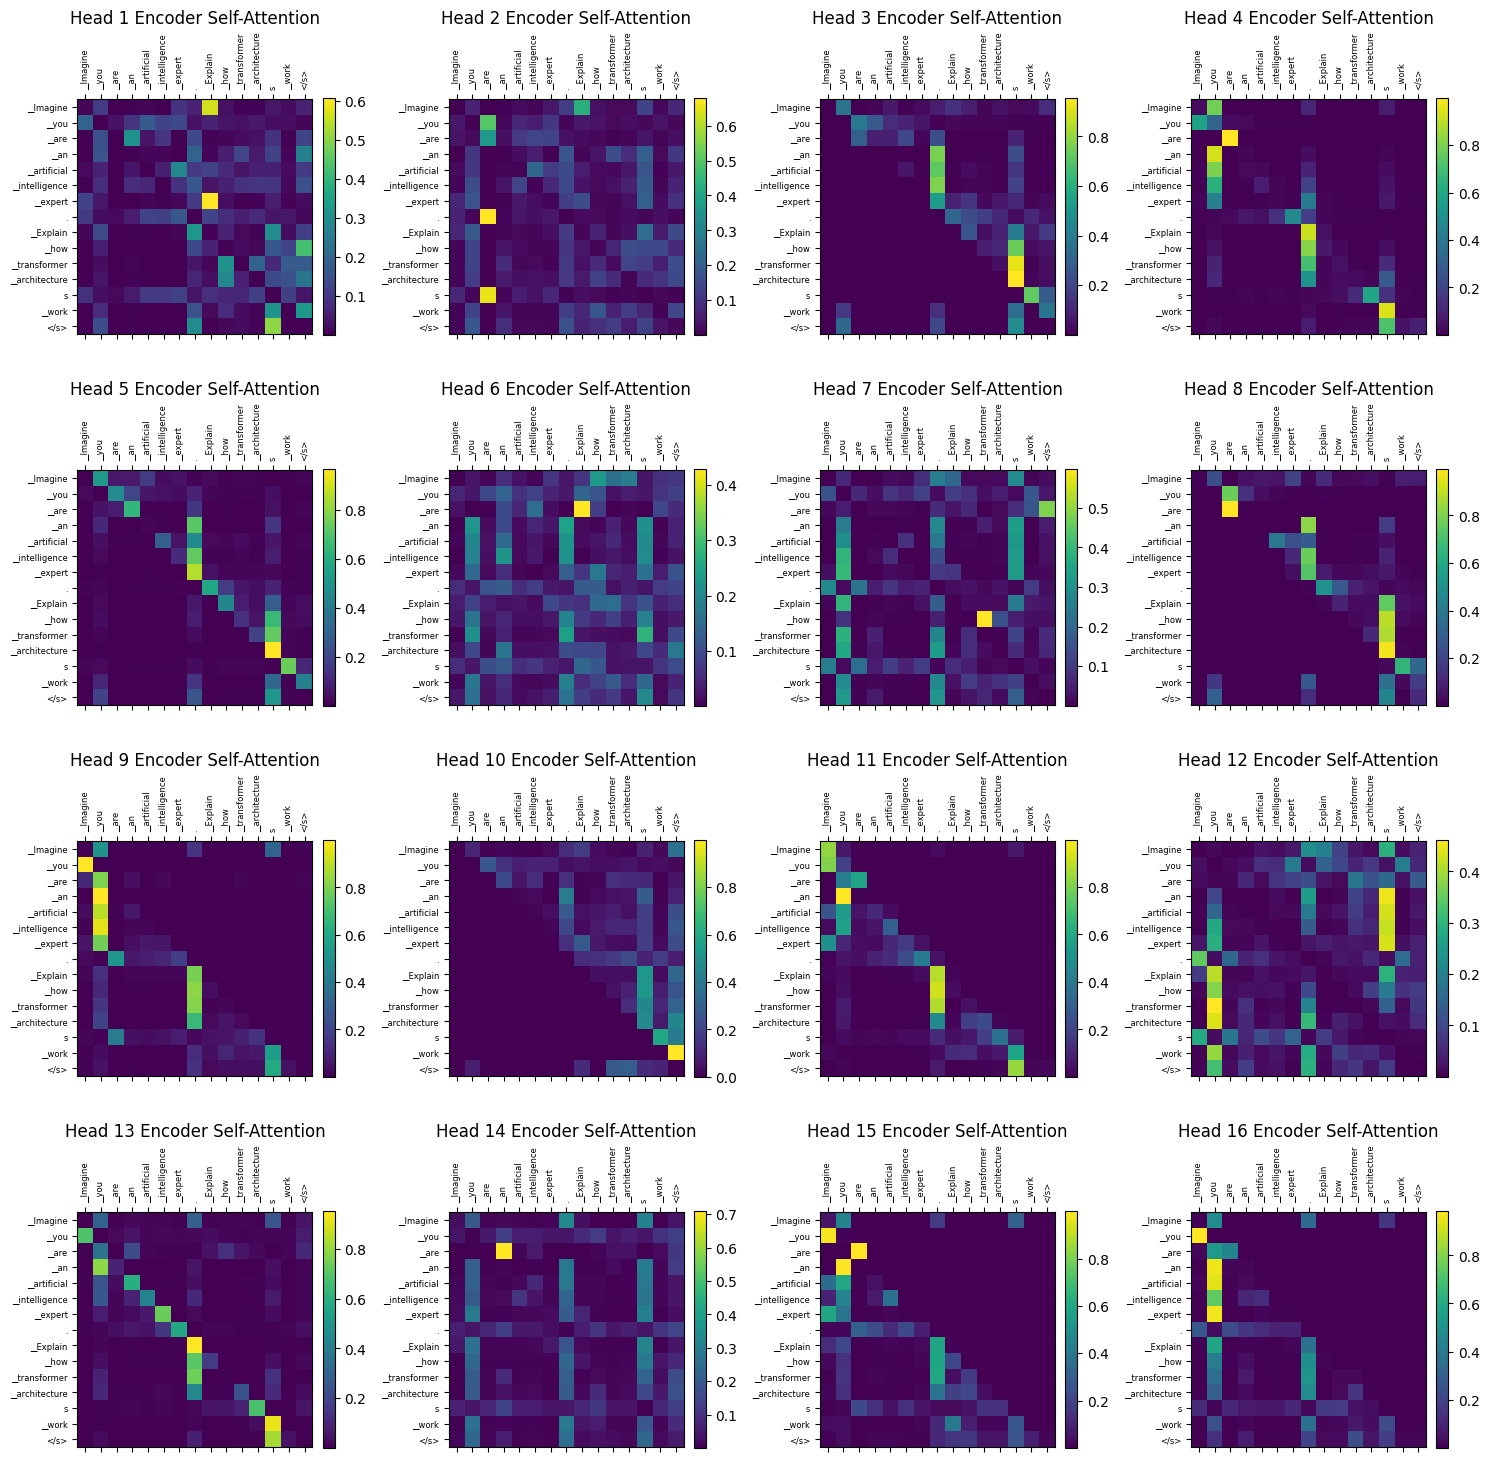

In [155]:
visualize_encoder_attention_per_head(new_prompt)